# Welcome to the cooltools visualization notebook!


Visualization is a crucial part of analyzing large-scale datasets. Before performing analyses of new Hi-C datasets, it is highly recommend to visualize the data. This notebook contains tips and tricks for visualization of coolers using cooltools.


Contents:
- loading coolers
- using matplotlib to visualize coolers
- filtering bins, balancing
- cis/total coverage, biases <todo>
- adaptive coarsegraining <todo>
- translocations, structural variants? yeast? <todo>
- higlass-python <todo>



In [23]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [24]:
### TODO: move this to a cooltools function: cooltools.download_test_data() (see seaborn/sci-kit implementation)
import requests
import tqdm
def download_file(url, local_filename=None):
    if local_filename is None:
        local_filename = url.split('/')[-1]
    print('downloading:', url, 'as ', local_filename)
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in tqdm.tqdm(r.iter_content(chunk_size=8192)): 
                f.write(chunk)
    return local_filename

In [27]:
if not os.path.exists('./test.mcool'):
    download_file('https://osf.io/3h9js/download','./test.mcool' )
    # this file is 145 Mb, and may take a few seconds to download

In [3]:
#import python package for working with cooler files: https://github.com/open2c/cooler
import cooler 

### Inspecting C data

The file we just downloaded, test.mcool, contains Micro-C data from HFF cells for two chromosomes in a [multi-resolution mcool format](https://cooler.readthedocs.io/en/latest/schema.html?highlight=mcool#multi-resolution).



In [38]:
# to print which resolutions are stored in the mcool, use list_coolers
cooler.fileops.list_coolers('./test.mcool')

['/resolutions/1000',
 '/resolutions/10000',
 '/resolutions/100000',
 '/resolutions/1000000']

In [44]:
### to load a cooler with a specific resolution use the following syntax:
clr = cooler.Cooler('./test.mcool::resolutions/1000000')

### to print chromosomes and binsize for this cooler
print(f'chromosomes: {clr.chromnames}, binsize: {clr.binsize}')

### to make a list of chromosome start/ends in bins:
chromstarts = []
for i in clr.chromnames:
    print(f'{i} : {clr.extent(i)}')
    chromstarts.append(clr.extent(i)[0])

chromosomes: ['chr2', 'chr17'], binsize: 1000000
chr2 : (0, 243)
chr17 : (243, 327)


Coolers store pairwise contact frequencies in sparse format, which can be fetched on demand as dense matrices. `clr.matrix` returns a matrix selector. The selector supports Python slice syntax `[]` and a `.fetch()` method. 
Slicing `clr.matrix()` with `[:]` fetches all bins in the cooler. Fetching can return either  balanced, or corrected, contact frequences `(balance=True)`, or raw counts prior to bias removal `(balance=False)`. Notice that there are higher contact frequencies within a chromosome as opposed to between chromosomes.

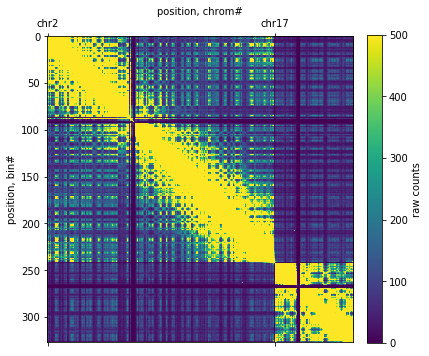

In [65]:
### to plot the raw  counts data with a linear colormap thresholded at 500 counts ###
f, ax = plt.subplots(
    figsize=(6,6))
im = ax.matshow((clr.matrix(balance=False)[:]),vmax=500); 
plt.colorbar(im ,fraction=0.046, pad=0.04, label='raw counts');
plt.xticks(chromstarts,clr.chromnames);
plt.xlabel('position, chrom#')
plt.ylabel('position, bin#')
ax = plt.gca()
ax.xaxis.set_label_position('top')


In [91]:
from matplotlib.ticker import EngFormatter

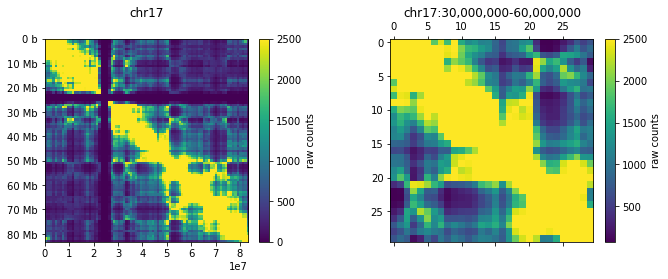

In [99]:
### we can fetch an individual chromosome or a region of a chromosome using cooler.fetch()
f, axs = plt.subplots(
    figsize=(10,4),
    ncols=2)

ax= axs[0]
im = ax.matshow((clr.matrix(balance=False).fetch('chr17')),vmax=2500, 
                extent=(0,clr.chromsizes['chr17'], clr.chromsizes['chr17'], 0)); 
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('bottom')
ax.set_title('chr17', y=1.08)
ax.yaxis.set_major_formatter(EngFormatter('b'))

ax= axs[1]
region = 'chr17:30,000,000-60,000,000'
im = ax.matshow((clr.matrix(balance=False).fetch(region)),vmax=2500, ); 
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.xaxis.set_label_position('top')
ax.set_title(region, y=1.08)
plt.tight_layout()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


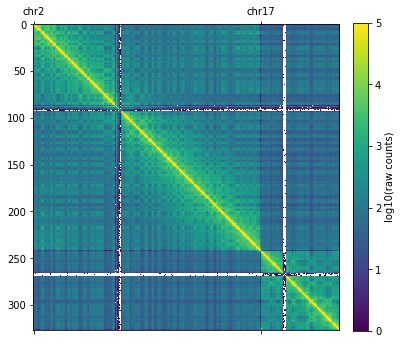

In [23]:
### plot the raw data in logscale ###
plt.figure(figsize=(6,6))
im = plt.matshow(np.log10(clr.matrix(balance=False)[:]), vmax=5,fignum=False); 
plt.colorbar(im ,fraction=0.046, pad=0.04, label='log10(raw counts)');
plt.xticks(chromstarts,clr.chromnames);

# its often useful to plot Hi-C data in log scale. Here zeros are evident as white stripes. 
# note that sparse white stripes appear at both centromeres. 


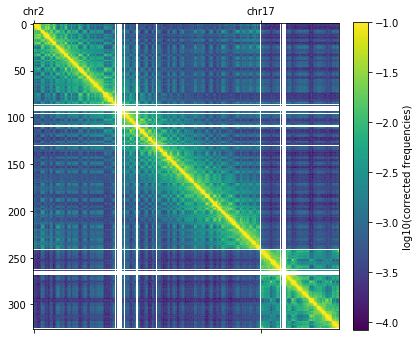

In [31]:
### plot the corrected data in logscale ###
plt.figure(figsize=(6,6))
im = plt.matshow(np.log10(clr.matrix()[:]), vmax=-1,fignum=False); 
plt.colorbar(im ,fraction=0.046, pad=0.04, label='log10(corrected frequencies)');
plt.xticks(chromstarts,clr.chromnames);

# note that scale differs after balancing: the rows & columns of the matrix are now normalized to sum to one
# also note that peri-centromeric bins have been completely removed in the normalized data


##### Colormaps
cooltools.lib.plotting has a set of colormaps that are useful for visualizing C data.
In particular, the fall colormap offers a high dynamic range, linear, option for visualizing Hi-C matrices


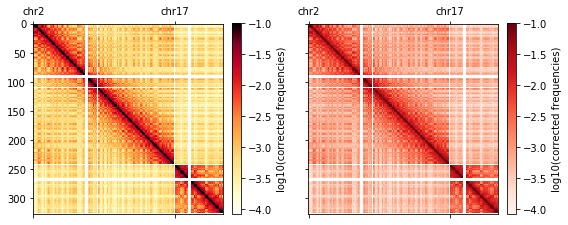

In [60]:
### plot the corrected data in fall heatmap ###
import cooltools.lib.plotting

f, axs = plt.subplots(
    figsize=(8,18),
    nrows=1, 
    ncols=2,
    sharex=True, sharey=True)

ax=  axs[0]
im = ax.matshow(np.log10(clr.matrix()[:]), vmax=-1,cmap='fall'); 
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='log10(corrected frequencies)');
plt.xticks(chromstarts,clr.chromnames);

ax=  axs[1]
im2 = ax.matshow(np.log10(clr.matrix()[:]), vmax=-1,cmap='Reds'); 
plt.colorbar(im2 ,fraction=0.046, pad=0.04, label='log10(corrected frequencies)');
plt.xticks(chromstarts,clr.chromnames);

plt.tight_layout()



In [ ]:
# - adaptive coarsegrain
### todo: 
# - cis/total coverage
# - biases
# - zoom into higher resolution
# - adaptive coarsegrain
# - translocations, yeast, etc..
# - higlass